In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import contextily as cx

import seaborn as sns
import os
from tqdm import tqdm

import shapely
from shapely.geometry import LineString, Point
from collections import Counter

import iteround

from sklearn.neighbors import KDTree
import importlib

In [2]:
import utils
importlib.reload(utils)

<module 'utils' from '/Users/francescmartiescofet/Documents/ETH/IVT/eqasim-java/switzerland/WaitTimeValidation/utils.py'>

!pip install seaborn
!pip install iteround
!pip install contextily
!pip install matplotlib-scalebar

### Load data needed

In [3]:
# get lakes
lake_path = "/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario/lake/g1s20.shp"

df_lakes = gpd.read_file(lake_path, geometry="geometry").to_crs("epsg:2056")
df_lakes.head()

,GMDNR,GMDNAME,SEE_HA,X_MIN,X_MAX,Y_MIN,Y_MAX,X_CNTR,Y_CNTR,E_MIN,E_MAX,N_MIN,N_MAX,E_CNTR,N_CNTR,geometry
0,9040,Greifensee,830,691665,695946,241896,247739,693800,245200,2691665,2695946,1241896,1247739,2693800,1245200,"POLYGON ((2692711.000 1247539.000, 2693291.000..."
1,9050,Zürichsee,8808,682601,714353,227657,247369,690500,235000,2682601,2714353,1227657,1247369,2690500,1235000,"POLYGON ((2690575.000 1236105.000, 2690885.000..."
2,9073,Thunersee,4784,614257,630110,167064,177247,621500,171200,2614257,2630110,1167064,1177247,2621500,1171200,"POLYGON ((2627651.000 1170385.000, 2628448.000..."
3,9089,Brienzersee,2977,634122,646789,170863,178693,640600,175000,2634122,2646789,1170863,1178693,2640600,1175000,"POLYGON ((2634105.000 1171525.000, 2634715.000..."
4,9148,Bielersee / Lac de Bienne,3970,572052,584660,209652,220433,578500,213800,2572052,2584660,1209652,1220433,2578500,1213800,"POLYGON ((2581863.000 1214635.000, 2580705.000..."


In [4]:
# get districts
geom_data_path = "/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario"
df_districts = gpd.read_file("%s/city_districts/data/stzh.adm_stadtkreise_v.shp" % geom_data_path,
                       encoding="latin1"
                      ).to_crs("epsg:2056")

# clean up
df_districts = df_districts.rename({"knr": "district_id", "kname": "district_name"}, axis=1)
df_districts = df_districts[["district_id", "district_name", "geometry"]].sort_values("district_id").reset_index(drop=True)
df_districts

,district_id,district_name,geometry
0,1,Kreis 1,"POLYGON ((2683358.477 1246403.556, 2683218.937..."
1,2,Kreis 2,"POLYGON ((2682296.566 1247016.328, 2682356.984..."
2,3,Kreis 3,"POLYGON ((2682296.566 1247016.328, 2682253.264..."
3,4,Kreis 4,"POLYGON ((2682296.566 1247016.328, 2682280.117..."
4,5,Kreis 5,"POLYGON ((2680537.632 1249894.533, 2680539.926..."
5,6,Kreis 6,"POLYGON ((2684316.434 1250651.586, 2684314.614..."
6,7,Kreis 7,"POLYGON ((2683860.979 1246723.697, 2683862.124..."
7,8,Kreis 8,"POLYGON ((2684280.850 1243932.550, 2683368.541..."
8,9,Kreis 9,"POLYGON ((2680390.466 1248340.821, 2680389.532..."
9,10,Kreis 10,"POLYGON ((2680537.632 1249894.533, 2680532.138..."


In [5]:
output_directory = '/Users/francescmartiescofet/Documents/ETH/IVT/eqasim-java/switzerland/SA_scenario_output'

drt_legs = utils.get_drt_legs(output_directory)

In [6]:
def convert_drt_legs_to_gpd(it_drt_legs):
    df = it_drt_legs.copy()
    df['origin_geometry'] = [Point(xy) for xy in zip(df.fromX, df.fromY)]
    df['destination_geometry'] = [Point(xy) for xy in zip(df.toX, df.toY)]
    df['geometry'] = df['origin_geometry']
    df = gpd.GeoDataFrame(df)
    df.crs = "epsg:2056"
    df["trip_id"] = [x for x in range(1, len(df)+1)]

    return df

In [7]:
it_drt_legs_gpd = convert_drt_legs_to_gpd(drt_legs[5])

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [8]:
it_drt_legs_gpd.head()

,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,...,travelTime,travelDistance_m,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime,origin_geometry,destination_geometry,geometry,trip_id
0,20394.0,201740003028284,drt2337,199217,2681198.89,1248025.61,246162,2680254.63,1249577.36,61.0,...,339.0,3627.25,3627.25,0,20994,21064.84,POINT (2681198.89 1248025.61),POINT (2680254.63 1249577.36),POINT (2681198.890 1248025.610),1
1,21703.0,201740003336656,drt1678,675408,2682050.18,1255754.71,925551,2683054.40,1255429.15,61.0,...,334.0,1557.34,1557.34,0,22303,22388.82,POINT (2682050.18 1255754.71),POINT (2683054.4 1255429.15),POINT (2682050.180 1255754.710),2
2,23457.0,201740003030787,drt2063,511450,2681806.44,1249393.77,456516,2683351.32,1247924.80,61.0,...,272.0,2730.29,2730.29,0,24057,24039.08,POINT (2681806.44 1249393.77),POINT (2683351.32 1247924.8),POINT (2681806.440 1249393.770),3
3,24834.0,201740003251660,drt2339,327283,2686042.63,1245901.99,796053,2686123.38,1245421.11,61.0,...,324.0,2857.00,2857.00,0,25434,25470.72,POINT (2686042.63 1245901.99),POINT (2686123.38 1245421.11),POINT (2686042.630 1245901.990),4
4,25087.0,201740003259821,drt2792,613352,2684695.46,1253388.39,261041,2683030.54,1254506.93,61.0,...,490.0,4026.41,4026.41,0,25687,25936.48,POINT (2684695.46 1253388.39),POINT (2683030.54 1254506.93),POINT (2684695.460 1253388.390),5


### function to impute zones
Here we do not fix by distance so default is set to false

In [9]:
#functions to input zones by points in a dataframe

def to_gpd(df, x="x", y="y", crs="epsg:2056", coord_type=""):
    df["geometry"] = [geo.Point(*coord) for coord in tqdm(zip(df[x], df[y]), total=len(df), desc="Converting %s coordinates" % coord_type)]
    df = gpd.GeoDataFrame(df)
    df.crs = crs

    if not crs == "epsg:2056":
        df = df.to_crs("epsg:2056")
        df.crs = "epsg:2056"

    return df

def impute(df_points, df_zones, point_id_field, zone_id_field, fix_by_distance=False, chunk_size=10000,
           zone_type="", point_type=""):
    assert (type(df_points) == gpd.GeoDataFrame)
    assert (type(df_zones) == gpd.GeoDataFrame)

    assert (point_id_field in df_points.columns)
    assert (zone_id_field in df_zones.columns)
    assert (not zone_id_field in df_points.columns)

    df_original = df_points
    df_points = df_points[[point_id_field, "geometry"]]
    df_zones = df_zones[[zone_id_field, "geometry"]]

    print("Imputing %d %s zones onto %d %s points by spatial join..."
          % (len(df_zones), zone_type, len(df_points), point_type))

    result = []
    chunk_count = max(1, int(len(df_points) / chunk_size))
    for chunk in tqdm(np.array_split(df_points, chunk_count)):
        result.append(gpd.sjoin(df_zones, chunk, predicate="contains", how="right"))
    
    df_points = pd.concat(result).reset_index()

    if "left_index" in df_points: del df_points["left_index"]
    if "right_index" in df_points: del df_points["right_index"]

    invalid_mask = pd.isnull(df_points[zone_id_field])

    if fix_by_distance and np.any(invalid_mask):
        print("  Fixing %d points by centroid distance join..." % np.count_nonzero(invalid_mask))
        coordinates = np.vstack([df_zones["geometry"].centroid.x, df_zones["geometry"].centroid.y]).T
        kd_tree = KDTree(coordinates)

        df_missing = df_points[invalid_mask]
        coordinates = np.vstack([df_missing["geometry"].centroid.x, df_missing["geometry"].centroid.y]).T
        indices = kd_tree.query(coordinates, return_distance=False).flatten()

        df_points.loc[invalid_mask, zone_id_field] = df_zones.iloc[indices][zone_id_field].values

    return pd.merge(df_original, df_points[[point_id_field, zone_id_field]], on=point_id_field, how="left")

def prepare_df_for_plot(df, zones, zone_id, metrics=["waitTime"]):
    joined_df = pd.merge(df, zones, on=zone_id, how="right") #merge on right to ensure all zones are showing
    
    ## computing metrics for plot
    mean_metrics = joined_df.groupby(zone_id)[metrics].mean().fillna(0).reset_index()

    for col in metrics:
        if "time" in col.lower():
            mean_metrics[col] /= 60
    mean_metrics = mean_metrics.round(1)
    return mean_metrics

### Assigning points to zones

In [10]:
## identify zones for origin location!!

df = impute(it_drt_legs_gpd, df_districts, "trip_id", "district_id",fix_by_distance=False).drop("geometry", axis=1)
display(df)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(df["district_id"])))

Imputing 12  zones onto 93  points by spatial join...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,...,travelTime,travelDistance_m,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime,origin_geometry,destination_geometry,trip_id,district_id
0,20394.0,201740003028284,drt2337,199217,2681198.89,1248025.61,246162,2680254.63,1249577.36,61.0,...,339.0,3627.25,3627.25,0,20994,21064.84,POINT (2681198.89 1248025.61),POINT (2680254.63 1249577.36),1,4.0
1,21703.0,201740003336656,drt1678,675408,2682050.18,1255754.71,925551,2683054.40,1255429.15,61.0,...,334.0,1557.34,1557.34,0,22303,22388.82,POINT (2682050.18 1255754.71),POINT (2683054.4 1255429.15),2,NaN
2,23457.0,201740003030787,drt2063,511450,2681806.44,1249393.77,456516,2683351.32,1247924.80,61.0,...,272.0,2730.29,2730.29,0,24057,24039.08,POINT (2681806.44 1249393.77),POINT (2683351.32 1247924.8),3,5.0
3,24834.0,201740003251660,drt2339,327283,2686042.63,1245901.99,796053,2686123.38,1245421.11,61.0,...,324.0,2857.00,2857.00,0,25434,25470.72,POINT (2686042.63 1245901.99),POINT (2686123.38 1245421.11),4,7.0
4,25087.0,201740003259821,drt2792,613352,2684695.46,1253388.39,261041,2683030.54,1254506.93,61.0,...,490.0,4026.41,4026.41,0,25687,25936.48,POINT (2684695.46 1253388.39),POINT (2683030.54 1254506.93),5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,78308.0,201740003229655,drt2209,544486,2683929.59,1250871.77,879945,2684146.24,1251161.36,61.0,...,93.0,491.61,491.61,0,78908,78651.20,POINT (2683929.59 1250871.77),POINT (2684146.24 1251161.36),89,11.0
89,78604.0,201740003062954,drt1252,565984,2682795.57,1250761.58,137882,2684166.51,1250677.67,61.0,...,269.0,2697.96,2697.96,0,79204,79183.94,POINT (2682795.57 1250761.58),POINT (2684166.51 1250677.67),90,6.0
90,79155.0,201740003099543,drt3243,967560,2684151.52,1247759.15,997451,2682943.58,1249526.03,61.0,...,343.0,2734.54,2734.54,0,79755,79765.15,POINT (2684151.52 1247759.15),POINT (2682943.58 1249526.03),91,7.0
91,83310.0,201740003229655,drt2209,879945,2684146.24,1251161.36,544486,2683929.59,1250871.77,61.0,...,93.0,491.61,491.61,0,83910,83650.14,POINT (2684146.24 1251161.36),POINT (2683929.59 1250871.77),92,11.0


no. of trips outside the district:  31


In [11]:
district_metrics = prepare_df_for_plot(df, df_districts, "district_id", metrics=["waitTime"])

In [12]:
district_metrics

,district_id,waitTime
0,1.0,0.0
1,2.0,1.0
2,3.0,1.2
3,4.0,1.2
4,5.0,1.0
5,6.0,1.3
6,7.0,1.0
7,8.0,1.7
8,9.0,1.1
9,10.0,1.3


In [13]:
#add Zurich or zonal overlay
def zurich_overlay(ax, number_districts=True, district_col="knr", lake_restriction = 'city'):
    # add lake
    if lake_restriction == 'city':
        city_shape = shapely.ops.unary_union([geo for geo in df_districts["geometry"]])
        f = df_lakes["geometry"].intersects(city_shape)
        df_lakes.loc[f, "geometry"].intersection(city_shape).plot(facecolor="skyblue", edgecolor="dodgerblue", ax=ax)
    else:
        f = df_lakes["geometry"].intersects(lake_restriction)
        df_lakes.loc[f, "geometry"].intersection(lake_restriction).plot(facecolor="skyblue", edgecolor="dodgerblue", ax=ax)

    # add districts with numbers
    df_districts.plot(facecolor="none", edgecolor="black", ax=ax)
    if number_districts:
        for _, row in df_districts.iterrows():    
            ax.text(row["geometry"].centroid.x, row["geometry"].centroid.y, str(row[district_col]), color="black", fontsize=20, verticalalignment='center', horizontalalignment='center')
        
    return ax

def add_scalebar(ax):
    # add scale bar
    scalebar = ScaleBar(1, font_properties={'size': 20}, location="lower left", frameon=False, box_color=None)
    ax.add_artist(scalebar)
    scalebar.get_fixed_value()
    
    return ax

def add_north(ax):
    
   # add north arrow
    x_min = ax.get_xbound()[0]
    x_max = ax.get_xbound()[1]
    dx = x_max - x_min

    y_min = ax.get_ybound()[0]
    y_max = ax.get_ybound()[1]
    dy = y_max - y_min

    ax.text(x=x_min, y=y_min + dy*0.1, s='N', fontsize=30)
    ax.arrow(x=x_min + dx*0.017, y=y_min + dy*0.14, 
           dx=0, dy=0, width=0,
           length_includes_head=False,
           head_width=500, head_length=500, overhang=.2, facecolor='k', edgecolor=None, linewidth=0, 
           head_starts_at_zero=False)
    
    return ax

In [14]:
def plot_zonal_avg(metrics, zones, column, lake_restriction='city'):
    sns.set_context("poster")
    fig, ax = plt.subplots(1, 1, figsize=(13, 13))

    # allow to adjust colormap
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
    fig.add_axes(cax)

    temp = gpd.GeoDataFrame(pd.merge(metrics, zones))
    temp.plot(column, 
              ax=ax, 
             #  vmin=2.0,
             #  vmax=6.0,
              legend=True,
              legend_kwds=dict(label="Average " + column + " [min]",
                               orientation="horizontal",
                               shrink=0.7,
                               cax=cax
                               ),
              alpha=1.0, 
              cmap='OrRd', 
              edgecolor="grey",
              )

    ax = zurich_overlay(ax, number_districts=True, district_col="district_id", lake_restriction=lake_restriction)
    ax = add_scalebar(ax)

    # add north arrow
    ax = add_north(ax)

    ax.set_axis_off()

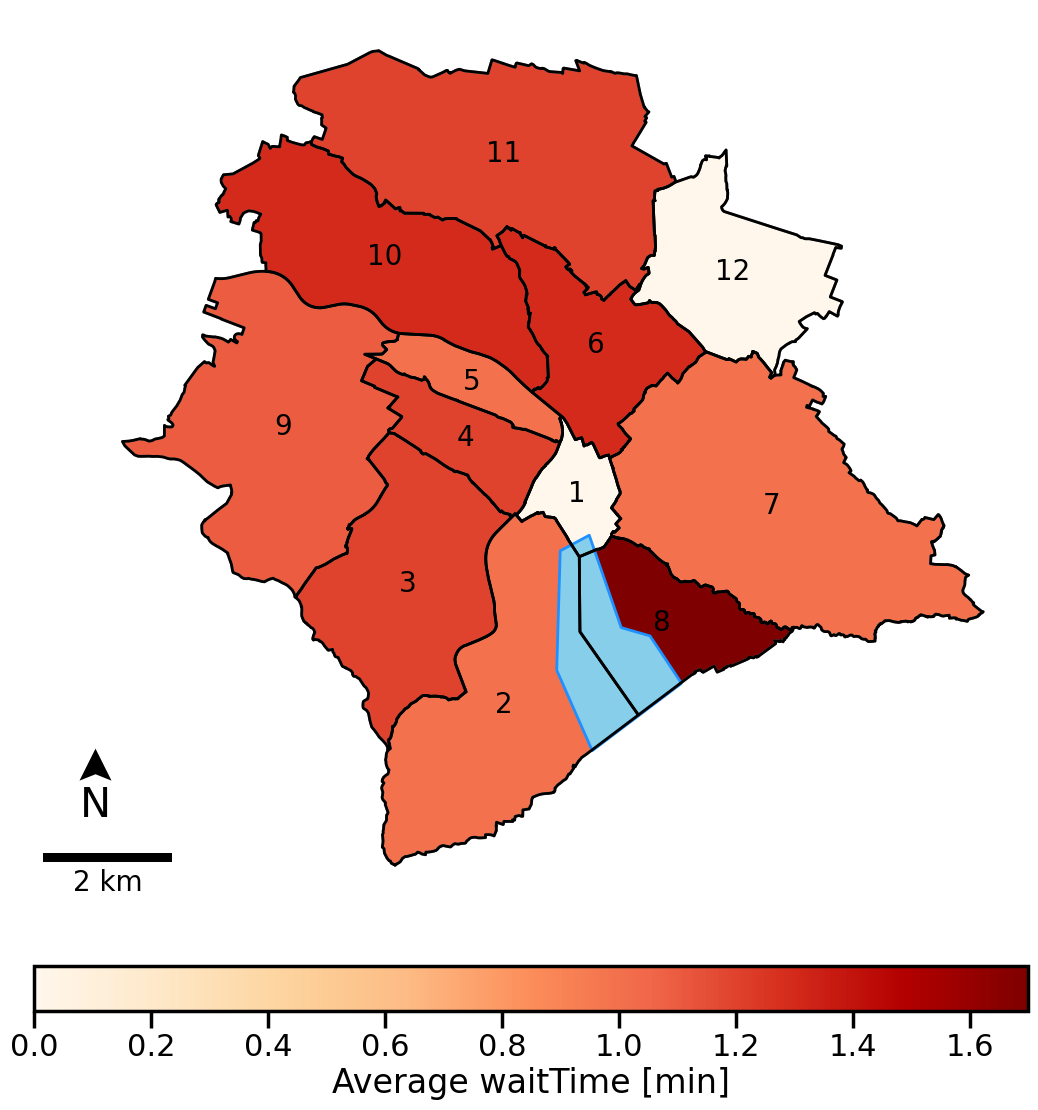

In [15]:
plot_zonal_avg(district_metrics, df_districts, 'waitTime')

In [16]:
def plot_column_by_trip_density(drt_legs_with_zone_id, zone_id_field, column):
    sns.set_context('notebook')
    grouped_by_n_trips = drt_legs_with_zone_id.groupby(zone_id_field) \
                            .agg(columnAvg=(column, 'mean'), nTrips=('trip_id','size')) \
                            .groupby('nTrips') \
                            .columnAvg.mean()
    plt.plot(grouped_by_n_trips)
    plt.xlabel('Number of trips in the simulated day')
    plt.ylabel('Average ' + column)
    plt.show()

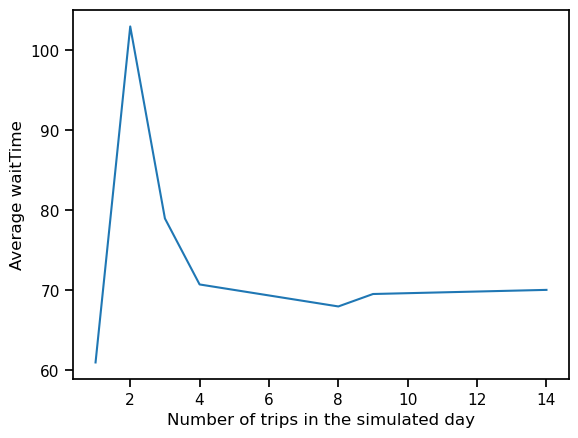

In [17]:
plot_column_by_trip_density(df, 'district_id', 'waitTime')

# Use our grid

In [18]:
zurich_shp_path = '/Users/francescmartiescofet/Documents/ETH/IVT/SA_scenario/ScenarioBoundary/zurich_city_5km.shp'
zurich_shp = gpd.read_file(zurich_shp_path)
grid = utils.create_grid_from_shapefile(zurich_shp_path, 500)

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [19]:
grid

,geometry,grid_id
2103,"POLYGON ((2693842.519 1242804.319, 2693727.193...",45_33
2102,"POLYGON ((2694135.101 1243304.319, 2694134.012...",45_32
2101,"POLYGON ((2694227.193 1243804.319, 2694227.193...",45_31
2147,"POLYGON ((2694348.764 1243804.319, 2694298.299...",46_31
2100,"POLYGON ((2694227.193 1244304.319, 2694227.193...",45_30
...,...,...
215,"POLYGON ((2673727.193 1243804.319, 2673727.193...",4_31
168,"POLYGON ((2673227.193 1244304.319, 2673227.193...",3_30
260,"POLYGON ((2674227.193 1244304.319, 2674227.193...",5_30
407,"POLYGON ((2675727.193 1239804.319, 2675727.193...",8_39


In [20]:
grid_drt_legs = impute(it_drt_legs_gpd, grid, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)
display(grid_drt_legs)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(grid_drt_legs["grid_id"])))

Imputing 1621  zones onto 93  points by spatial join...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,...,travelTime,travelDistance_m,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime,origin_geometry,destination_geometry,trip_id,grid_id
0,20394.0,201740003028284,drt2337,199217,2681198.89,1248025.61,246162,2680254.63,1249577.36,61.0,...,339.0,3627.25,3627.25,0,20994,21064.84,POINT (2681198.89 1248025.61),POINT (2680254.63 1249577.36),1,19_22
1,21703.0,201740003336656,drt1678,675408,2682050.18,1255754.71,925551,2683054.40,1255429.15,61.0,...,334.0,1557.34,1557.34,0,22303,22388.82,POINT (2682050.18 1255754.71),POINT (2683054.4 1255429.15),2,21_7
2,23457.0,201740003030787,drt2063,511450,2681806.44,1249393.77,456516,2683351.32,1247924.80,61.0,...,272.0,2730.29,2730.29,0,24057,24039.08,POINT (2681806.44 1249393.77),POINT (2683351.32 1247924.8),3,21_19
3,24834.0,201740003251660,drt2339,327283,2686042.63,1245901.99,796053,2686123.38,1245421.11,61.0,...,324.0,2857.00,2857.00,0,25434,25470.72,POINT (2686042.63 1245901.99),POINT (2686123.38 1245421.11),4,29_26
4,25087.0,201740003259821,drt2792,613352,2684695.46,1253388.39,261041,2683030.54,1254506.93,61.0,...,490.0,4026.41,4026.41,0,25687,25936.48,POINT (2684695.46 1253388.39),POINT (2683030.54 1254506.93),5,26_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,78308.0,201740003229655,drt2209,544486,2683929.59,1250871.77,879945,2684146.24,1251161.36,61.0,...,93.0,491.61,491.61,0,78908,78651.20,POINT (2683929.59 1250871.77),POINT (2684146.24 1251161.36),89,25_16
89,78604.0,201740003062954,drt1252,565984,2682795.57,1250761.58,137882,2684166.51,1250677.67,61.0,...,269.0,2697.96,2697.96,0,79204,79183.94,POINT (2682795.57 1250761.58),POINT (2684166.51 1250677.67),90,23_17
90,79155.0,201740003099543,drt3243,967560,2684151.52,1247759.15,997451,2682943.58,1249526.03,61.0,...,343.0,2734.54,2734.54,0,79755,79765.15,POINT (2684151.52 1247759.15),POINT (2682943.58 1249526.03),91,25_23
91,83310.0,201740003229655,drt2209,879945,2684146.24,1251161.36,544486,2683929.59,1250871.77,61.0,...,93.0,491.61,491.61,0,83910,83650.14,POINT (2684146.24 1251161.36),POINT (2683929.59 1250871.77),92,25_16


no. of trips outside the district:  0


In [21]:
grid_metrics = prepare_df_for_plot(grid_drt_legs, grid, "grid_id", metrics=["waitTime"])

In [22]:
grid_metrics

,grid_id,waitTime
0,0_17,0.0
1,0_18,0.0
2,0_19,0.0
3,0_20,0.0
4,0_21,0.0
...,...,...
1616,9_5,0.0
1617,9_6,0.0
1618,9_7,0.0
1619,9_8,0.0


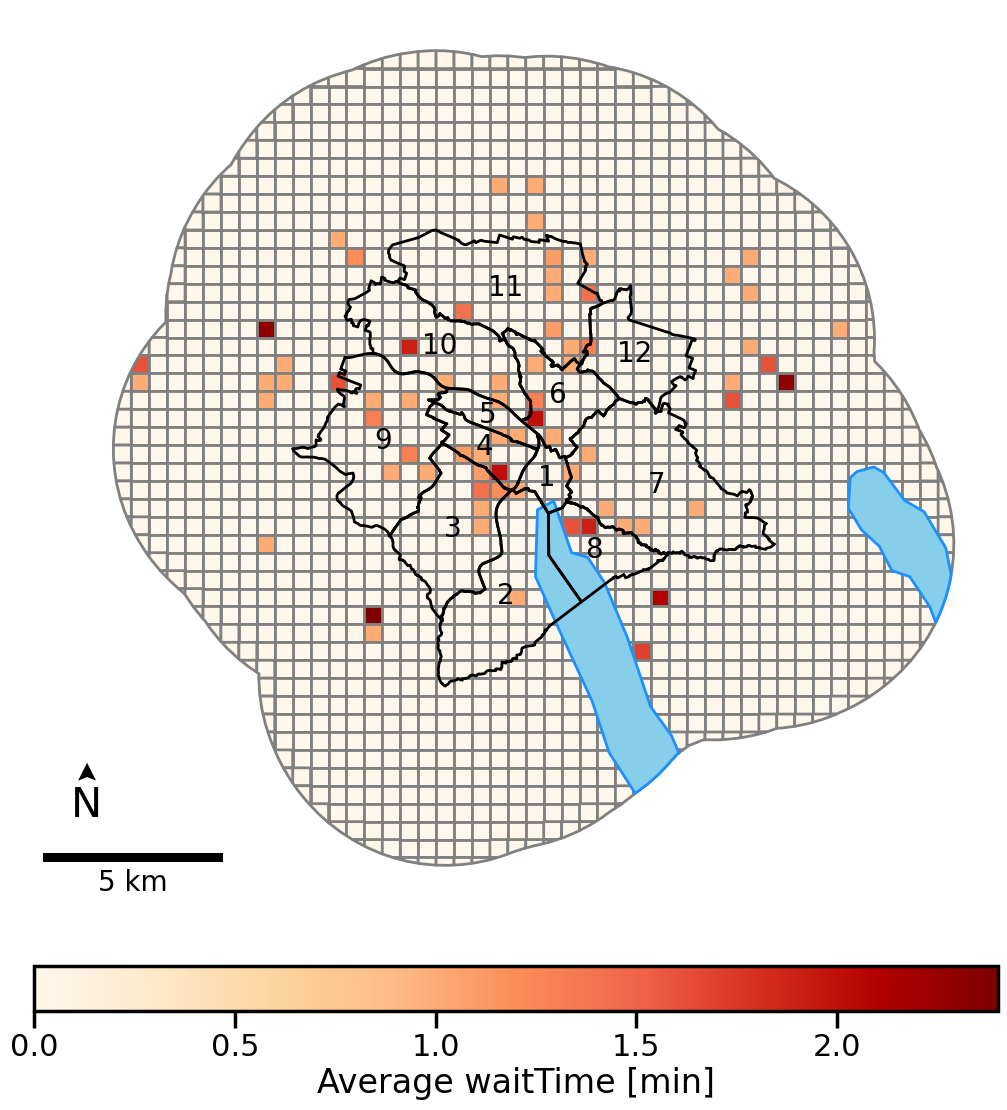

In [23]:
plot_zonal_avg(grid_metrics, grid, 'waitTime', lake_restriction=zurich_shp.loc[0].geometry)

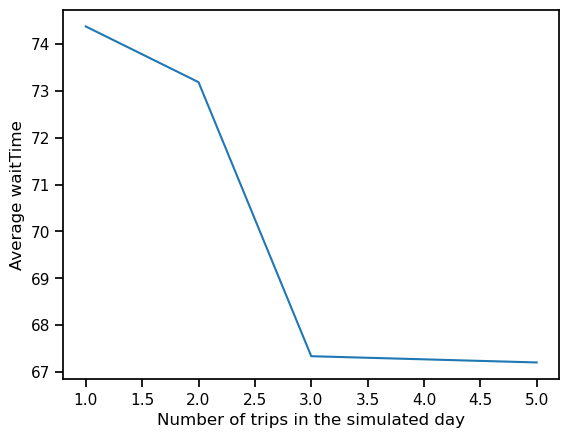

In [24]:
plot_column_by_trip_density(grid_drt_legs, 'grid_id', 'waitTime')

In [25]:
grid_drt_legs.groupby('grid_id').agg(avgWaitTime=('waitTime', 'mean'), nTrips=('trip_id','size')).groupby('nTrips').avgWaitTime.mean()

nTrips
1    74.377358
2    73.187500
3    67.333333
5    67.200000
Name: avgWaitTime, dtype: float64

# Testing with output from class project

In [26]:
class_project_drt_legs_gdf = convert_drt_legs_to_gpd(pd.read_csv('/Users/francescmartiescofet/Desktop/28.drt_trips_drt.csv', sep=';'))

/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/francescmartiescofet/miniconda3/envs/IVT/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [27]:
class_project_drt_legs_gdf

,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,arrivalTime,travelTime,travelDistance_m,direcTravelDistance_m,origin_geometry,destination_geometry,geometry,trip_id
0,33.0,201740010683213,drt3356,211875,2679787.33,1250708.55,364724,2682983.54,1251935.52,112.0,745.0,600.0,4389.29,4389.29,POINT (2679787.33 1250708.55),POINT (2682983.54 1251935.52),POINT (2679787.330 1250708.550),1
1,36.0,201740010451177,drt1281,215298,2676574.54,1250203.97,151179,2674395.66,1247008.94,31.0,903.0,836.0,7633.48,6707.79,POINT (2676574.54 1250203.97),POINT (2674395.66 1247008.94),POINT (2676574.540 1250203.970),2
2,37.0,201740009842715,drt3848,253250,2684841.48,1253046.32,364724,2682983.54,1251935.52,104.0,508.0,367.0,2775.24,2775.24,POINT (2684841.48 1253046.32),POINT (2682983.54 1251935.52),POINT (2684841.480 1253046.320),3
3,41.0,201740003622835,drt2945,329394,2686858.53,1250489.90,364724,2682983.54,1251935.52,365.0,1204.0,798.0,5154.32,5154.32,POINT (2686858.53 1250489.9),POINT (2682983.54 1251935.52),POINT (2686858.530 1250489.900),4
4,44.0,201740007721765,drt883,644309,2681088.72,1252916.96,789074,2683215.51,1248676.27,295.0,1356.0,1017.0,6358.01,6358.01,POINT (2681088.72 1252916.96),POINT (2683215.51 1248676.27),POINT (2681088.720 1252916.960),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88850,106508.0,201740004345615,drt2372,462552,2684121.02,1246098.93,516964,2687458.81,1244684.47,152.0,107308.0,648.0,4588.50,4588.50,POINT (2684121.02 1246098.93),POINT (2687458.81 1244684.47),POINT (2684121.020 1246098.930),88851
88851,106513.0,201740003906606,drt2544,193966,2682651.37,1247493.68,30182,2685572.68,1248520.54,399.0,107784.0,872.0,5431.43,5431.43,POINT (2682651.37 1247493.68),POINT (2685572.68 1248520.54),POINT (2682651.370 1247493.680),88852
88852,106581.0,201740006253397,drt1462,644372,2681511.90,1248373.10,410256,2685912.65,1251076.99,67.0,107338.0,690.0,6709.98,6709.98,POINT (2681511.9 1248373.1),POINT (2685912.65 1251076.99),POINT (2681511.900 1248373.100),88853
88853,106634.0,201740004880949,drt3815,376659,2684538.51,1253141.39,949133,2682995.52,1251283.11,93.0,107149.0,422.0,3175.27,3175.27,POINT (2684538.51 1253141.39),POINT (2682995.52 1251283.11),POINT (2684538.510 1253141.390),88854


In [28]:
grid_drt_legs_class = impute(class_project_drt_legs_gdf, grid, "trip_id", "grid_id",fix_by_distance=False).drop("geometry", axis=1)
display(grid_drt_legs_class)
#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(grid_drt_legs_class["grid_id"])))

Imputing 1621  zones onto 88855  points by spatial join...


100%|██████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.88it/s]


,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,arrivalTime,travelTime,travelDistance_m,direcTravelDistance_m,origin_geometry,destination_geometry,trip_id,grid_id
0,33.0,201740010683213,drt3356,211875,2679787.33,1250708.55,364724,2682983.54,1251935.52,112.0,745.0,600.0,4389.29,4389.29,POINT (2679787.33 1250708.55),POINT (2682983.54 1251935.52),1,17_17
1,36.0,201740010451177,drt1281,215298,2676574.54,1250203.97,151179,2674395.66,1247008.94,31.0,903.0,836.0,7633.48,6707.79,POINT (2676574.54 1250203.97),POINT (2674395.66 1247008.94),2,10_18
2,37.0,201740009842715,drt3848,253250,2684841.48,1253046.32,364724,2682983.54,1251935.52,104.0,508.0,367.0,2775.24,2775.24,POINT (2684841.48 1253046.32),POINT (2682983.54 1251935.52),3,27_12
3,41.0,201740003622835,drt2945,329394,2686858.53,1250489.90,364724,2682983.54,1251935.52,365.0,1204.0,798.0,5154.32,5154.32,POINT (2686858.53 1250489.9),POINT (2682983.54 1251935.52),4,31_17
4,44.0,201740007721765,drt883,644309,2681088.72,1252916.96,789074,2683215.51,1248676.27,295.0,1356.0,1017.0,6358.01,6358.01,POINT (2681088.72 1252916.96),POINT (2683215.51 1248676.27),5,19_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88850,106508.0,201740004345615,drt2372,462552,2684121.02,1246098.93,516964,2687458.81,1244684.47,152.0,107308.0,648.0,4588.50,4588.50,POINT (2684121.02 1246098.93),POINT (2687458.81 1244684.47),88851,25_26
88851,106513.0,201740003906606,drt2544,193966,2682651.37,1247493.68,30182,2685572.68,1248520.54,399.0,107784.0,872.0,5431.43,5431.43,POINT (2682651.37 1247493.68),POINT (2685572.68 1248520.54),88852,22_23
88852,106581.0,201740006253397,drt1462,644372,2681511.90,1248373.10,410256,2685912.65,1251076.99,67.0,107338.0,690.0,6709.98,6709.98,POINT (2681511.9 1248373.1),POINT (2685912.65 1251076.99),88853,20_21
88853,106634.0,201740004880949,drt3815,376659,2684538.51,1253141.39,949133,2682995.52,1251283.11,93.0,107149.0,422.0,3175.27,3175.27,POINT (2684538.51 1253141.39),POINT (2682995.52 1251283.11),88854,26_12


no. of trips outside the district:  85


In [29]:
grid_drt_legs_class['geometry'] = grid_drt_legs_class['origin_geometry']
grid_drt_legs_class_gdf = gpd.GeoDataFrame(grid_drt_legs_class)
grid_drt_legs_class_gdf.crs = "epsg:2056"
#grid_drt_legs_class[pd.isna(grid_drt_legs_class["grid_id"])]

<AxesSubplot: >

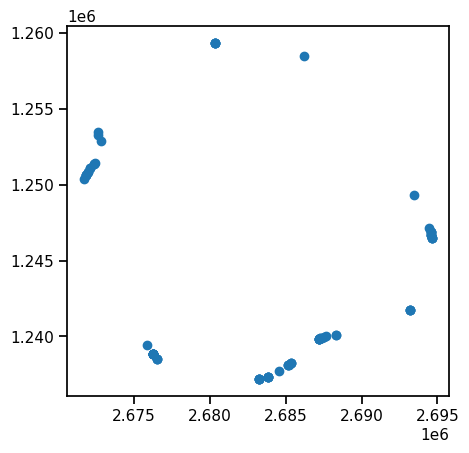

In [30]:
grid_drt_legs_class_gdf[pd.isna(grid_drt_legs_class["grid_id"])].plot()

In [31]:
grid_metrics_class = prepare_df_for_plot(grid_drt_legs_class, grid, "grid_id", metrics=["waitTime"])

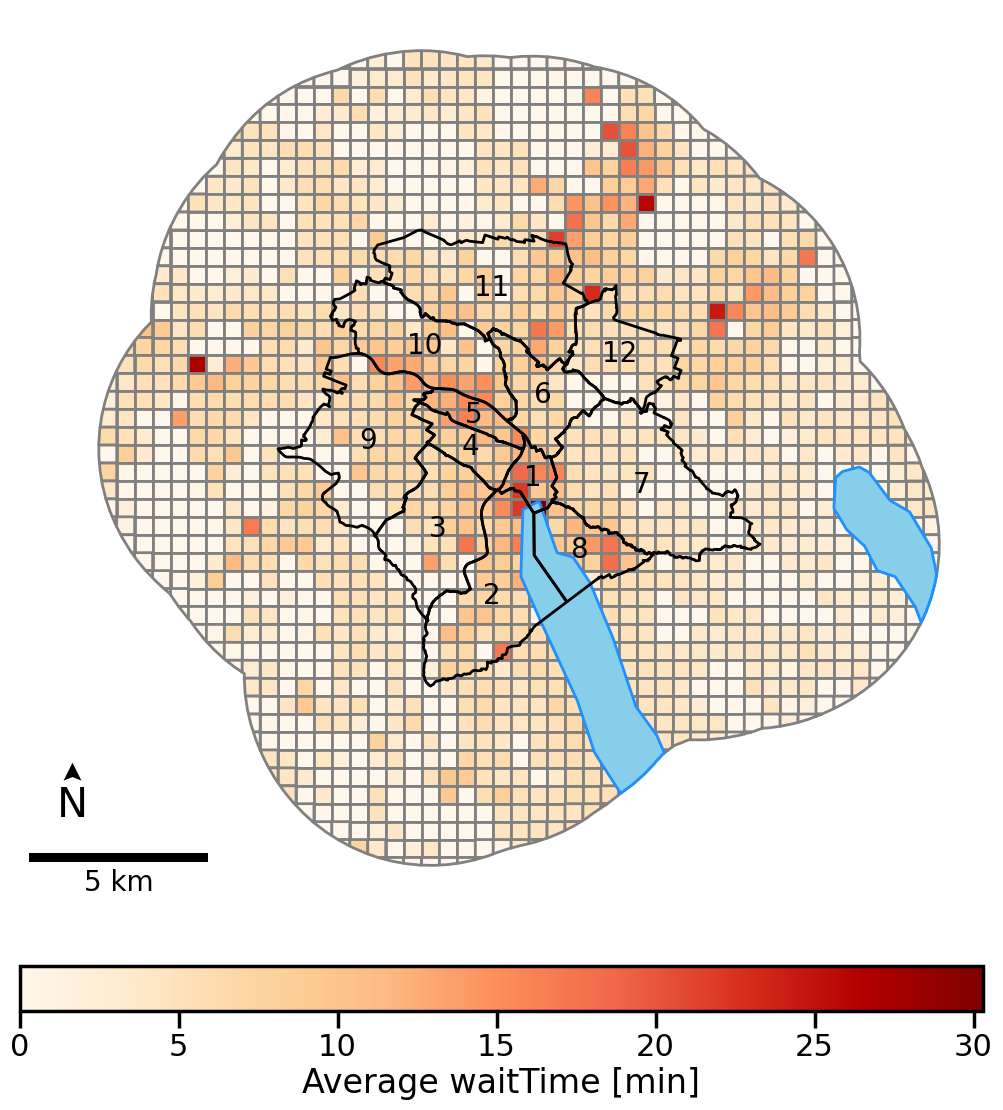

In [32]:
plot_zonal_avg(grid_metrics_class, grid, 'waitTime', lake_restriction=zurich_shp.loc[0].geometry)

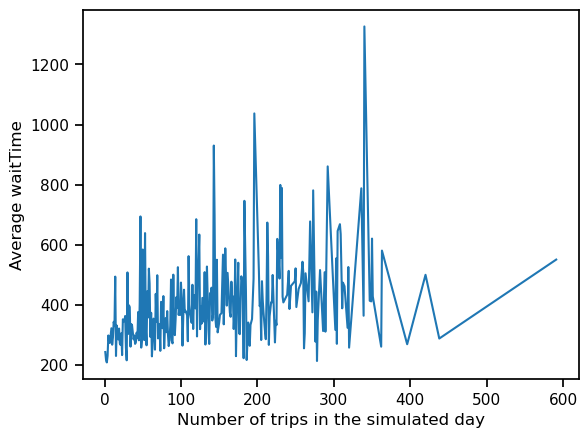

In [33]:
plot_column_by_trip_density(grid_drt_legs_class, 'grid_id', 'waitTime')